In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import glob
import os.path as osp
import numpy as np
from PIL import Image
import os
import time
import matplotlib.pyplot as plt
import utils

# Generate adversarial images

In [ ]:
def fool(images,
         labels,
         model,
         target,
         epsilon=5e-2,
         num_iters=100,
         max_L2_norm=None):
    '''
    Generate adversarial images utilizing the Fast Gradient Sign method
    Arguments:
        - input_imgs: torch tensor of input images
        - model: model used to make predictions
        - target: class to trick the model into predicting
        - epsilon: scalar by which to multiply gradient when perturbing natural input
        - num_iters: maximum number of times to add a perturbation to image
    '''
    start = time.time()
    images = images.clone()
    
    # Subset batch:
    # Only keep images that are correctly classified
    # Only keep images not already belonging to target class
    pred = torch.argmax(model(images), 1)
    mask = (pred == labels) * (labels != target)
    images, labels = images[mask], labels[mask]
    original_images, original_labels = images.clone(), labels.clone()
    
    images.requires_grad_(True)  # very important!
    # We don't need the gradients of anything else
    for param in model.parameters():
        param.requires_grad_(False)
    
    perturbation = torch.zeros_like(images)
    fooled = False
    iteration = 0

    dout = torch.zeros_like(model(images), dtype=torch.float)
    dout[:,target] = 1.  # only compute gradient w.r.t. target class
    
    required_iters = torch.ones_like(labels).type(torch.float)

    while fooled is False and iteration < num_iters:
        
        output = model(images)
        model.zero_grad() # zero out all gradients in model so they don't accumulate
        grad = torch.autograd.grad(outputs=output, inputs=images, grad_outputs=dout)[0]
        
        with torch.no_grad():
            perturbation.add_(epsilon * grad )
            images.add_(epsilon * grad )
                        
            predictions = torch.argmax(model(images), 1)
            
            # If an example is correctly predicted, set all upward gradients
            # flowing to that example to zero; we've successfully found an
            # adversarial image that tricks the model and no longer need to 
            # update the original. We keep looping to try to find successful
            # adversarial images for the other examples.
            dout[:,target] = (predictions != target)
            required_iters.add_( (predictions != target).type(torch.float) )
            
            # If every adversarial example fooled the model, we're done
            if (predictions == target).sum() == labels.size(0):
                fooled = True
            iteration += 1
            
    print('Took {:.2f} seconds'.format(time.time() - start))
    print('Required iterations: \n{}'.format(required_iters))
            
    return (original_images, original_labels, perturbation.detach(), images.detach())

In [ ]:
def make_adv_dataset():
    '''
    Create a dataset of adversarial images
    
    
    take as input what?
    - maybe you should make this a class
    - init loads all data of a certain type (MNIST vs CIFAR)
    - init loads a pretrained model (for either MNIST or CIFAR)
    - make a separate utils.py file that does these two tasks
    
    methods
    - fool() method.
        - Make a class attribute be the generated adversarial set?
        - This will use the attributes of a pretrained model and dataset initialized in init
        - Have options specifying how many adversarial images to generate
    - a testing/calibration method for testing out the parameters that you'll use in fool() method
    - Method to visualize side by side 
    - Method to create an adversarial dataset
        - input should be the filename of where the created dataset will be stored. Save as a pickle?
    - You'll need to write somewhere a function that takes as input the saved pickle and 
        creates a Pytorch dataset/dataloader from it. 
        - This will take as input the path to the pickle
        - Optional input arguments: the original class and the target class. You'll have to do 
            some subsetting/slicing for this. Should be very straightforward
    
    
    '''
    return

In [ ]:
t = utils.get_data('cifar')

In [ ]:
s = utils.trained_model('cifar')

In [56]:
import utils

class Adversarial_utils:
    '''
    Class that helps to experiment with adversarial 
    image generation. Also contains functionality to 
    create an adversarial image dataset
    '''
    def __init__(self, dataset):
        assert (dataset == 'cifar' or dataset == 'mnist'), \
            'Dataset must either be \'cifar\' or \'mnist\''
        self.dataset = dataset
        self.data = utils.get_data(dataset)
        self.model = utils.trained_model(dataset)
    
    def fool_calibrate(self, target, epsilon=1e-2, num_iters=100, max_L2_norm=None):
        '''
        Generate a set of adversarial images from a random batch of data
        '''
        images, labels = iter(self.data).next()
        images, labels = images.clone(), labels.clone()
        
        self.calibrate_data = self.fool(images, 
                                        labels, 
                                        target, 
                                        epsilon=epsilon, 
                                        num_iters=num_iters, 
                                        max_L2_norm=max_L2_norm,
                                        calibrate=True)
        self.visualize()

    def visualize(self):
        '''
        Visualize the adversarial images and perturbations generated 
        with fool_calibrate()
        '''
        original_images, original_labels, pert_images, adv_images, required_iters, pert_norm = self.calibrate_data
        predictions = torch.argmax(self.model(adv_images),1)

        num_fooled = (predictions != original_labels).sum()
        print('Successfully fooled {}/{}\n'.format(num_fooled, len(original_labels)))

        for i in range(len(adv_images)):
            pred = predictions[i].clone()
            label = original_labels[i].clone()
            required_iter = required_iters[i].clone()
            norm = pert_norm[i].clone()

            adv_im = adv_images[i].clone()
            pert_im = pert_images[i].clone()
            original_im = original_images[i].clone()
            
            # In order to plot, normalize so pixels are in range [0,1]
            pert_im = pert_im - pert_im.min()
            pert_im = pert_im/pert_im.max()
            
            if self.dataset == 'cifar':
                _cmap = None
                adv_im = adv_im.squeeze(0).numpy().transpose((1,2,0))
                pert_im = pert_im.squeeze(0).numpy().transpose((1,2,0))
                original_im = original_im.squeeze(0).numpy().transpose((1,2,0))
            
            if self.dataset == 'mnist':
                _cmap = 'binary_r'
                adv_im = adv_im.squeeze(0).numpy()
                pert_im = pert_im.squeeze(0).numpy()
                original_im = original_im.squeeze(0).numpy()
                        

            print('Original Label: {}'.format(label))
            print('Model prediction: {}'.format(pred))

            # Plot adversary
            plt.subplot(1,3,1)
            plt.imshow(adv_im, cmap=_cmap)
            plt.title('Adversary')
            plt.xticks([])
            plt.yticks([])

            # Plot perturbation
            plt.subplot(1,3,2)
            plt.imshow(pert_im, cmap=_cmap)
            plt.title('Iters: {:.0f}, Norm: {:.3f}'.format(required_iter, norm))
            plt.xticks([])
            plt.yticks([])

            # Plot original
            plt.subplot(1,3,3)
            plt.imshow(original_im, cmap=_cmap)
            plt.title('Original')
            plt.xticks([])
            plt.yticks([])

            plt.show()
            print('\n')

            
    def fool(self, 
             images, 
             labels, 
             target, 
             epsilon=5e-2, 
             num_iters=100, 
             max_L2_norm=None,
             calibrate=False):
        '''
        Generated adversarial images for a batch of data contained in argument images
        '''
        
        start = time.time()  # Keep track of how long this takes

        # Subset batch:
        # Only keep images that are correctly classified
        # Only keep images not already belonging to target class
        pred = torch.argmax(self.model(images), 1)
        mask = (pred == labels) * (labels != target)
        images, labels = images[mask], labels[mask]
        original_images, original_labels = images.clone(), labels.clone()

        images.requires_grad_(True)  # very important!
        # We don't need the gradients of anything else
        for param in self.model.parameters():
            param.requires_grad_(False)

        perturbation = torch.zeros_like(images)
        fooled = False
        iteration = 0

        dout = torch.zeros_like(self.model(images), dtype=torch.float)
        dout[:,target] = 1.  # only compute gradient w.r.t. target class

        required_iters = torch.ones_like(labels).type(torch.float)

        while fooled is False and iteration < num_iters:

            output = self.model(images)
            self.model.zero_grad() # zero out all gradients in model so they don't accumulate
            grad = torch.autograd.grad(outputs=output, inputs=images, grad_outputs=dout)[0]

            with torch.no_grad():
                proposed_perturbation = epsilon * grad

                # Make sure pixels in resulting image are in [0,1]
                pert_upper_bound = torch.ones_like(images) - images
                pert_lower_bound = - images
                proposed_perturbation = torch.min(proposed_perturbation, pert_upper_bound)
                proposed_perturbation = torch.max(proposed_perturbation, pert_lower_bound)

                # Update images and perturbation
                perturbation.add_(proposed_perturbation)
                images.add_(proposed_perturbation)
                
                # If an example is correctly predicted, set all upward gradients
                # flowing to that example to zero; we've successfully found an
                # adversarial image that tricks the model and no longer need to 
                # update the original. We keep looping to try to find successful
                # adversarial images for the other examples.
                predictions = torch.argmax(self.model(images), 1)
                dout[:,target] = (predictions != target)
                required_iters.add_( (predictions != target).type(torch.float) )

                # If every adversarial example fooled the model, we're done
                if (predictions == target).sum() == labels.size(0):
                    fooled = True
                iteration += 1
                
        # Only keep images if their norms are small enough
        with torch.no_grad():
            pert_norm = torch.norm(perturbation.view(perturbation.size(0),-1), dim=1)
            if max_L2_norm is not None:
                mask = (pert_norm < max_L2_norm)
                images, labels = images[mask], labels[mask]
                required_iters = required_iters[mask]
                pert_norm = pert_norm[mask]
                original_images, original_labels = images.clone(), labels.clone()
        
        print('Took {:.2f} seconds'.format(time.time() - start))

        if calibrate:
            return (original_images, original_labels, perturbation.detach(), 
                    images.detach(), required_iters, pert_norm)
        else:
            return (original_images, original_labels, 
                    perturbation.detach(), images.detach())
        
        
    def make_dataset(file_name):
        '''
        Create a dataset of adversarial images
        '''
        pass

    

In [57]:
t = Adversarial_utils('cifar')


Took 1.25 seconds
Successfully fooled 39/39

Original Label: 6
Model prediction: 8


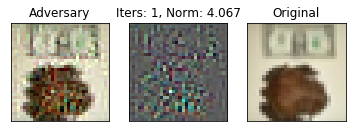



Original Label: 4
Model prediction: 8


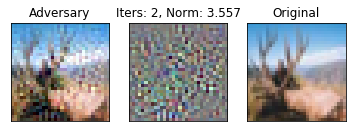



Original Label: 6
Model prediction: 8


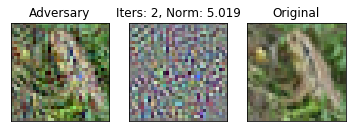



Original Label: 7
Model prediction: 8


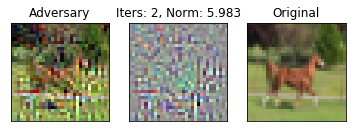



Original Label: 3
Model prediction: 8


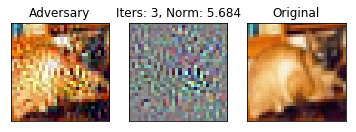



Original Label: 9
Model prediction: 8


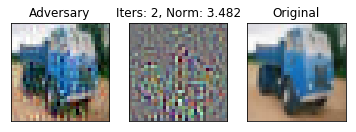



Original Label: 9
Model prediction: 8


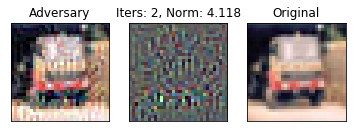



Original Label: 0
Model prediction: 8


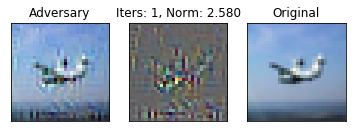



Original Label: 2
Model prediction: 8


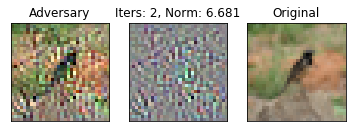



Original Label: 3
Model prediction: 8


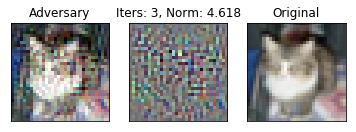



Original Label: 1
Model prediction: 8


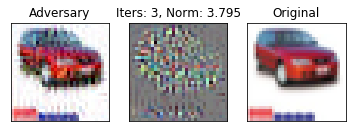



Original Label: 3
Model prediction: 8


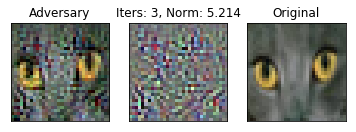



Original Label: 5
Model prediction: 8


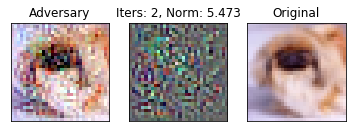



Original Label: 1
Model prediction: 8


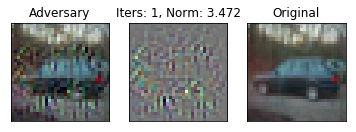



Original Label: 0
Model prediction: 8


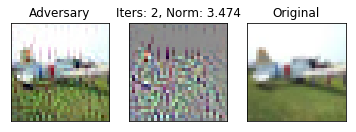



Original Label: 0
Model prediction: 8


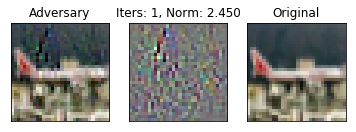



Original Label: 4
Model prediction: 8


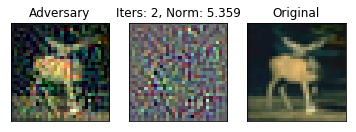



Original Label: 0
Model prediction: 8


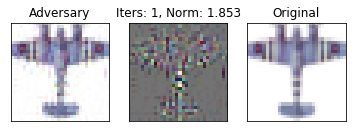



Original Label: 0
Model prediction: 8


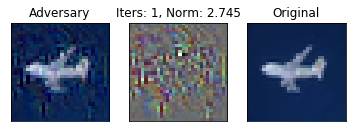



Original Label: 1
Model prediction: 8


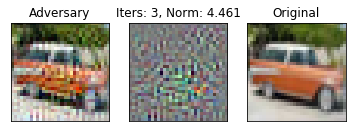



Original Label: 1
Model prediction: 8


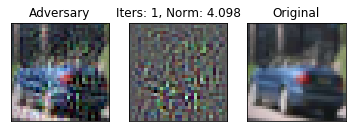



Original Label: 4
Model prediction: 8


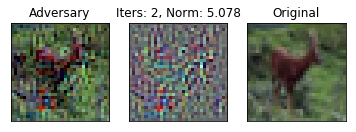



Original Label: 3
Model prediction: 8


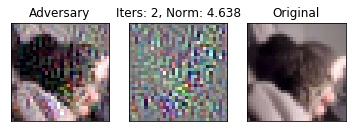



Original Label: 6
Model prediction: 8


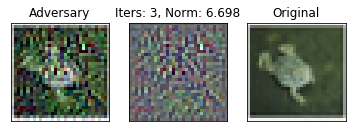



Original Label: 7
Model prediction: 8


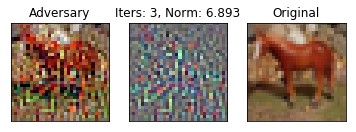



Original Label: 9
Model prediction: 8


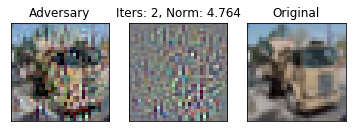



Original Label: 1
Model prediction: 8


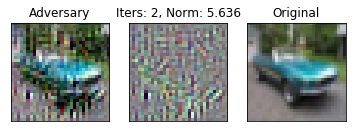



Original Label: 9
Model prediction: 8


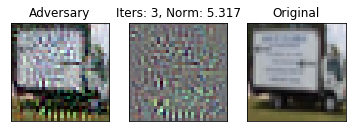



Original Label: 0
Model prediction: 8


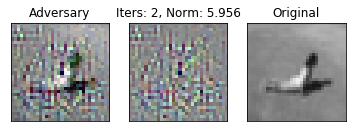



Original Label: 5
Model prediction: 8


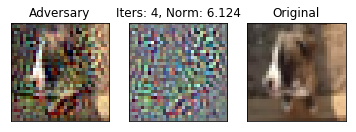



Original Label: 0
Model prediction: 8


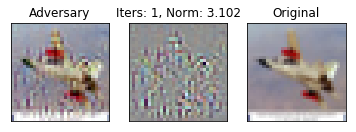



Original Label: 1
Model prediction: 8


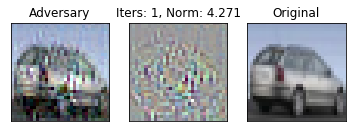



Original Label: 5
Model prediction: 8


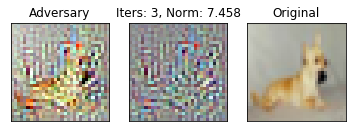



Original Label: 6
Model prediction: 8


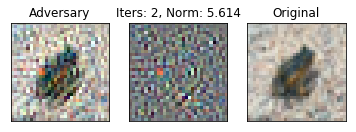



Original Label: 5
Model prediction: 8


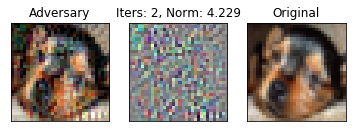



Original Label: 9
Model prediction: 8


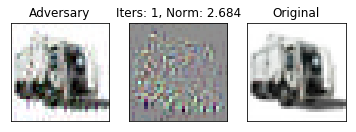



Original Label: 4
Model prediction: 8


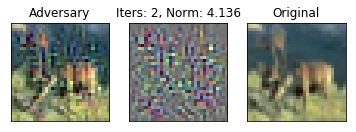



Original Label: 1
Model prediction: 8


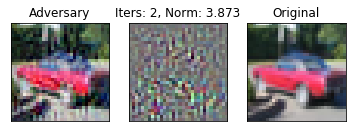



Original Label: 3
Model prediction: 8


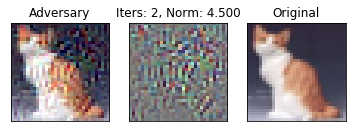

In [58]:
t.fool_calibrate(8, epsilon=1e-1)


In [59]:
s = Adversarial_utils('mnist')


Took 0.86 seconds
Successfully fooled 45/45

Original Label: 3
Model prediction: 8


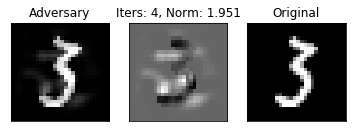



Original Label: 1
Model prediction: 8


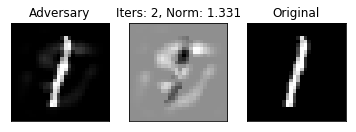



Original Label: 5
Model prediction: 8


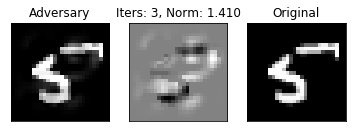



Original Label: 7
Model prediction: 8


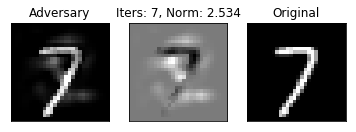



Original Label: 0
Model prediction: 8


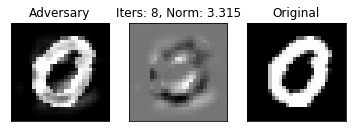



Original Label: 1
Model prediction: 8


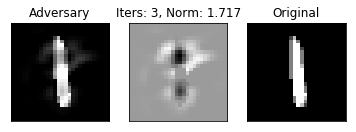



Original Label: 0
Model prediction: 8


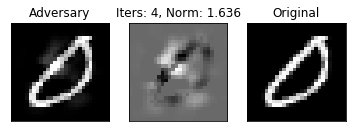



Original Label: 9
Model prediction: 8


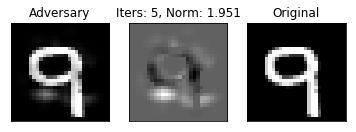



Original Label: 7
Model prediction: 8


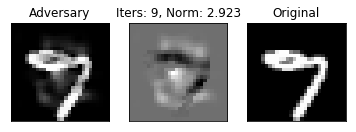



Original Label: 1
Model prediction: 8


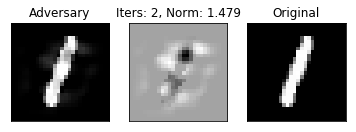



Original Label: 0
Model prediction: 8


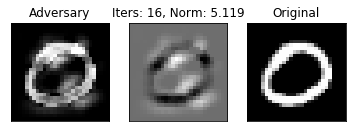



Original Label: 7
Model prediction: 8


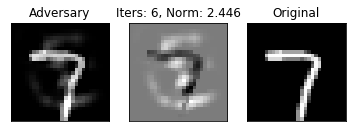



Original Label: 6
Model prediction: 8


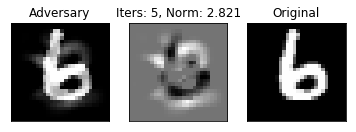



Original Label: 4
Model prediction: 8


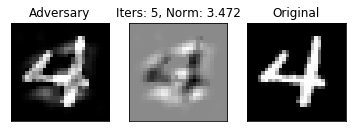



Original Label: 3
Model prediction: 8


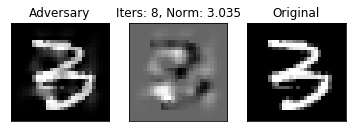



Original Label: 5
Model prediction: 8


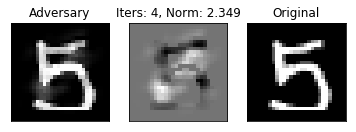



Original Label: 7
Model prediction: 8


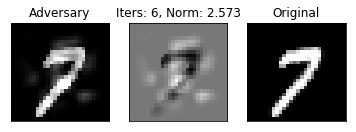



Original Label: 9
Model prediction: 8


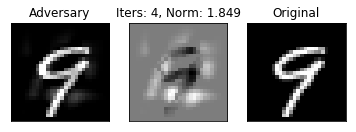



Original Label: 7
Model prediction: 8


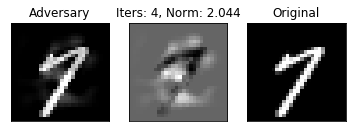



Original Label: 7
Model prediction: 8


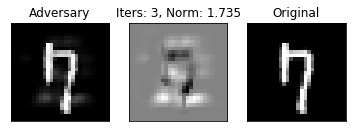



Original Label: 0
Model prediction: 8


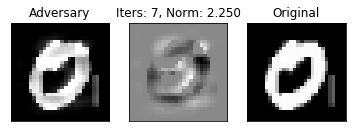



Original Label: 6
Model prediction: 8


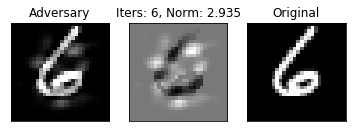



Original Label: 1
Model prediction: 8


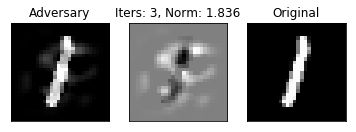



Original Label: 2
Model prediction: 8


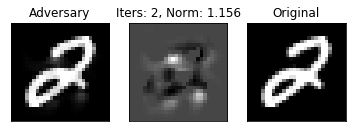



Original Label: 0
Model prediction: 8


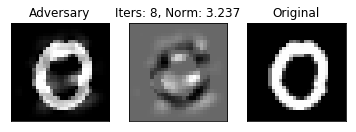



Original Label: 1
Model prediction: 8


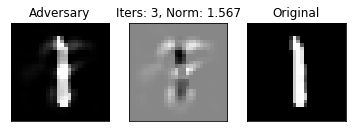



Original Label: 3
Model prediction: 8


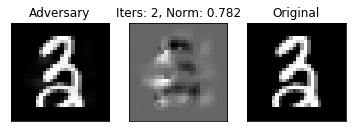



Original Label: 1
Model prediction: 8


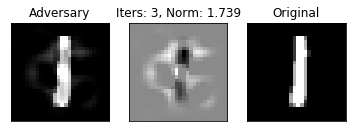



Original Label: 4
Model prediction: 8


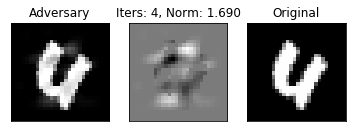



Original Label: 1
Model prediction: 8


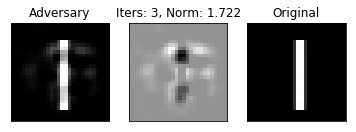



Original Label: 2
Model prediction: 8


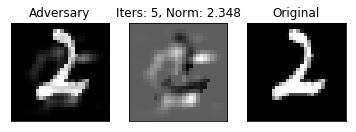



Original Label: 6
Model prediction: 8


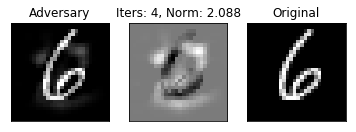



Original Label: 3
Model prediction: 8


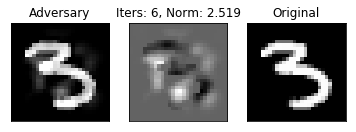



Original Label: 2
Model prediction: 8


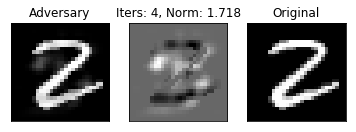

In [ ]:
s.fool_calibrate(8, epsilon=1e-1)


In [6]:
a = utils.get_data('mnist')
b = utils.trained_model('mnist')


In [11]:
c, d = iter(a).next()


In [17]:
torch.argmax(b(c),1) == d


tensor([ 1,  1,  1,  1,  1,  1,  1,  1,  1,  0,  1,  1,  1,  1,
         1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
         1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
         1,  1,  1,  1,  1,  1,  1,  1], dtype=torch.uint8)